In [38]:
import midynet, graphinf
import matplotlib.pyplot as plt
import numpy as np
import time
import tqdm
import seaborn as sns
import pandas as pd
import pathlib
from itertools import product

from midynet.utility import display

from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network._base import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from scipy.special import xlogy
from netrd.reconstruction import NaiveTransferEntropy, GrangerCausality

def training_data(X, n_train_samples=10, resample_graph=True):
    x, y = [], []
    for _ in range(n_train_samples):
        if resample_graph:
            X.sample_prior()
        X.sample_state()
        x.append(X.get_past_states())
        y.append(X.get_future_states())
    x, y = np.array(x), np.array(y)
    x = np.transpose(x, (1, 2, 0)).reshape(X.get_size(), -1).T
    y = np.transpose(y, (1, 2, 0)).reshape(X.get_size(), -1).T
    return x, y

class MultiLogisticRegression():
    def __init__(self, **params):
        self.params = params
    
    def fit(self, X, y):
        n = y.shape[1]
        self._models = [LogisticRegression(**self.params).fit(X, y[:, i]) for i in range(n)]
        return self
    
    def predict(self, X):
        return np.array([m.predict_proba(X)[:,1] for m in self._models]).T
        
def avg_probs(X, n_samples=100):
    og = X.get_graph()
    probs = np.array(X.get_transition_matrix()).T / n_samples
    for _ in range(n_samples):
        X.sample_prior()
        probs += np.array(X.get_transition_matrix()).T / n_samples
    X.set_graph(og)
    return probs

In [13]:
J = np.linspace(0, 2, 20)
# T = [5, 10, 20, 25, 50, 100, 150, 200, 300, 400, 500]
n_samples = 500
# data = defaultdict(list)

G = graphinf.graph.ErdosRenyiModel(5, 5, loopy=False, multigraph=False)

for j in tqdm.tqdm(J):
    X = graphinf.data.dynamics.GlauberDynamics(G, length=100, coupling=j)
    x_train, y_train = training_data(X, n_train_samples=100)
    logistic = MultiLogisticRegression().fit(x_train, y_train)
    mlp = MLPClassifier().fit(x_train, y_train)
    for _ in range(n_samples):
        X.sample()
        data["j"].append(j)
        data["likelihood"].append(-X.log_likelihood())
        data["evidence"].append(-X.log_evidence(method="exact"))
        data["mi"].append(X.log_likelihood() + data["evidence"][-1])
        
        x_test, y_test = np.array(X.get_past_states()).T, np.array(X.get_future_states()).T
        true = np.array(X.get_transition_matrix()).T
        pred = logistic.predict(x_test)
        data["pred-loss-logistic"].append(np.abs(y_test - pred).sum())
        
        pred[y_test == 0] = 1 - pred[y_test == 0]
#         data["pred-loss"].append(xlogy(y_test, pred).sum())
        data["pred-error-logistic"].append(np.abs(true - pred).sum())
    
        pred = mlp.predict_proba(x_test)
        data["pred-loss-mlp"].append(np.abs(y_test - pred).sum())
        pred[y_test == 0] = 1 - pred[y_test == 0]
#         data["pred-loss"].append(xlogy(y_test, pred).sum())
        data["pred-error-mlp"].append(np.abs(true - pred).sum())
        
        reconstructor = NaiveTransferEntropy()
        reconstructor.fit(x_test.T)
        data["recon-auc-te"].append(
            roc_auc_score(
                np.array(X.get_graph().get_adjacency_matrix(True)).flatten(),
                reconstructor.results["weights_matrix"].flatten()
            )
        )
        
        reconstructor = GrangerCausality()
        reconstructor.fit(x_test.T)
        data["recon-auc-gc"].append(
            roc_auc_score(
                np.array(X.get_graph().get_adjacency_matrix(True)).flatten(),
                reconstructor.results["weights_matrix"].flatten()
            )
        )



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:31<00:00, 16.55s/it]


In [22]:
df

,j,likelihood,evidence,mi,pred-loss-logistic,pred-error-logistic,pred-loss-mlp,pred-error-mlp,recon-auc-te,recon-auc-gc,pred,recon,norm-error-logistic,norm-error-mlp
0,0.0,346.573590,346.573590,0.000000,249.660274,5.066763,249.420509,10.002123,0.720000,0.786667,0.000000,0.000000,0.020295,0.040101
1,0.0,346.573590,346.573590,0.000000,250.143015,5.420347,250.179630,10.330979,0.553333,0.580000,0.000000,0.000000,0.021669,0.041294
2,0.0,346.573590,346.573590,0.000000,250.218718,5.549379,250.141972,10.818628,0.620000,0.740000,0.000000,0.000000,0.022178,0.043250
3,0.0,346.573590,346.573590,0.000000,249.875727,5.341392,249.967350,10.470855,0.780000,0.693333,0.000000,0.000000,0.021376,0.041889
4,0.0,346.573590,346.573590,0.000000,249.941524,5.501310,249.755075,10.160738,0.560000,0.433333,0.000000,0.000000,0.022010,0.040683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2.0,14.681616,19.517896,4.836280,98.636983,94.792727,55.379258,51.413516,0.470000,0.546667,0.247787,0.874644,0.961026,0.928389
19996,2.0,16.484573,20.268991,3.784418,13.989181,10.568205,14.678866,11.345290,0.673333,0.563333,0.186710,0.684414,0.755456,0.772900
19997,2.0,29.164512,34.671382,5.506870,33.029907,24.713868,34.873260,28.058059,0.810000,0.753333,0.158830,0.995920,0.748227,0.804572
19998,2.0,26.838487,31.665210,4.826723,20.528547,14.243765,22.208114,17.009608,0.600000,0.466667,0.152430,0.872915,0.693852,0.765919


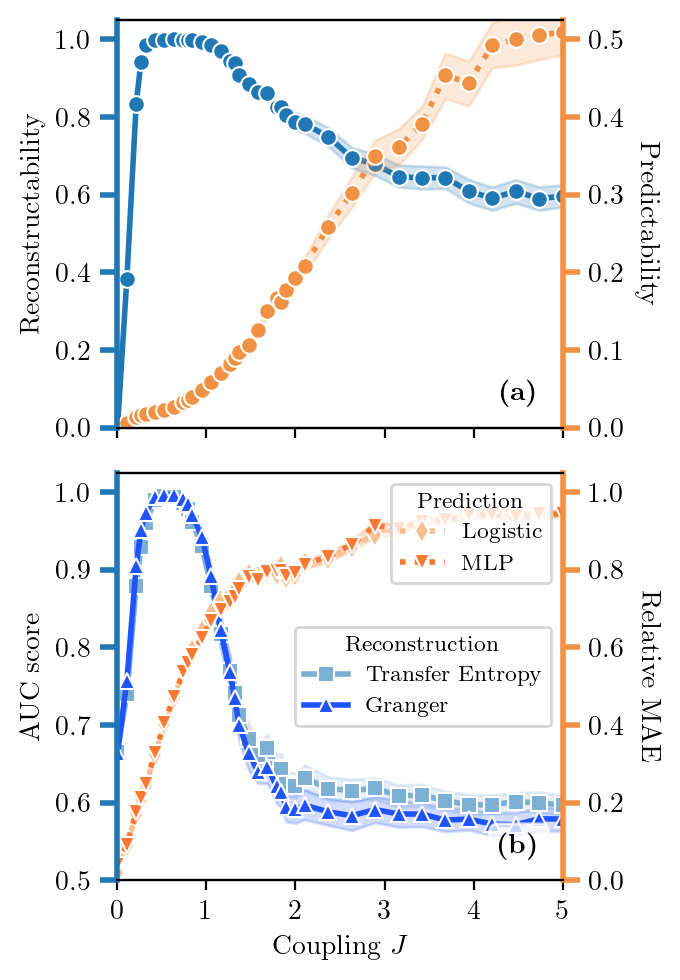

In [63]:
df = pd.DataFrame(data)

df["pred"] = df["mi"] / df["evidence"]
df["recon"] = df["mi"] / -G.log_joint()
df["norm-error-logistic"] = df["pred-error-logistic"] / df["pred-loss-logistic"]
df["norm-error-mlp"] = df["pred-error-mlp"] / df["pred-loss-mlp"]

fig, ax = plt.subplots(2, 1, figsize=(3.5, 5), sharex=True)

sns.lineplot(
    df, x="j", y="recon", 
    ax=ax[0], 
    color=display.med_colors["blue"], 
    linewidth=2, 
    marker="o", 
    linestyle="-"
)
axx0 = ax[0].twinx()

sns.lineplot(
    df, x="j", y="pred", 
    ax=axx0, 
    color=display.med_colors["orange"], 
    linewidth=2, 
    marker="o", 
    linestyle="dotted"
)
ax[0].set_ylabel("Reconstructability", fontsize=display.fontsizes["label"])
axx0.set_ylabel(r"Predictability", fontsize=display.fontsizes["label"], rotation=-90, ha="center", va="bottom")
ax[0].set_xlabel(r"Coupling $J$", fontsize=display.fontsizes["label"])
ax[0].tick_params(axis="both", labelsize=display.fontsizes["label"])
axx0.tick_params(axis="both", labelsize=display.fontsizes["label"])

# handles = [
#     display.get_label_line("Reconstructability", style=ax[0].get_lines()[0]),
#     display.get_label_line("Predictability", style=axx0.get_lines()[0]),
# ]
# axx0.legend(handles=handles, loc="upper right", fontsize=display.fontsizes["legend"])

sns.lineplot(
    df, x="j", y="recon-auc-te", 
    ax=ax[1], 
    color=display.light_colors["blue"], 
    linewidth=2,
    marker="s",
    linestyle="-",
)
sns.lineplot(
    df, x="j", y="recon-auc-gc", 
    ax=ax[1], 
    color=display.dark_colors["blue"], 
    linewidth=2,
    marker="^",
    linestyle="-",
)
axx1 = ax[1].twinx()

sns.lineplot(
    df, x="j", y="norm-error-logistic", 
    ax=axx1, 
    color=display.light_colors["orange"], 
    linewidth=2,
    marker="d",
    linestyle="dotted",
)
sns.lineplot(
    df, x="j", y="norm-error-mlp", 
    ax=axx1, 
    color=display.dark_colors["orange"], 
    linewidth=2,
    marker="v",
    linestyle="dotted",
)
ax[1].set_xlabel(r"Coupling $J$", fontsize=display.fontsizes["label"])
ax[1].set_ylabel(r"AUC score", fontsize=display.fontsizes["label"])
# ax[1].set_ylim([0.5, 1])
axx1.set_ylabel(r"Relative MAE", fontsize=display.fontsizes["label"], rotation=-90, ha="center", va="bottom")
ax[1].tick_params(axis="both", labelsize=display.fontsizes["label"])
axx1.tick_params(axis="both", labelsize=display.fontsizes["label"])

handles = [
    display.get_label_line("Transfer Entropy", style=ax[1].get_lines()[0]),
    display.get_label_line("Granger", style=ax[1].get_lines()[1]),
]
ax[1].legend(handles=handles, loc="center right", title="Reconstruction", title_fontsize=display.fontsizes["legend"], fontsize=display.fontsizes["legend"])

handles = [
    display.get_label_line("Logistic", style=axx1.get_lines()[0]),
    display.get_label_line("MLP", style=axx1.get_lines()[1]),
]
axx1.legend(handles=handles, loc="upper right", title="Prediction", title_fontsize=display.fontsizes["legend"], fontsize=display.fontsizes["legend"])
ax[0].set_xlim([0, 5])
ax[0].set_ylim([0, 1.05])
axx0.set_ylim([0, 0.525])
ax[0].tick_params(axis='y', color=display.med_colors["blue"], length=6, width=2)
axx0.tick_params(axis='y', color=display.med_colors["orange"], length=6, width=2)
axx0.spines['left'].set_color(display.med_colors["blue"])
axx0.spines['left'].set_linewidth(2)
axx0.spines['right'].set_color(display.med_colors["orange"])
axx0.spines['right'].set_linewidth(2)

ax[1].set_xlim([0, 5])
ax[1].set_ylim([0.5, 1.025])
axx1.set_ylim([0, 1.05])
ax[1].tick_params(axis='y', color=display.med_colors["blue"], length=6, width=2)
axx1.tick_params(axis='y', color=display.med_colors["orange"], length=6, width=2)
axx1.spines['left'].set_color(display.med_colors["blue"])
axx1.spines['left'].set_linewidth(2)
axx1.spines['right'].set_color(display.med_colors["orange"])
axx1.spines['right'].set_linewidth(2)
display.Label.clear()
display.Label.plot(ax[0], loc="bottom right")
display.Label.plot(ax[1], loc="bottom right")

fig.tight_layout()

paths = [pathlib.Path(".")]
for p, fmt in product(paths, ["svg", "pdf", "png"]):
    fig.savefig(p / f"{fmt}/heuristic-duality.{fmt}", bbox_inches='tight')


In [128]:
import tqdm.notebook as tqdm
from collections import defaultdict

In [162]:
J = np.linspace(0, 4, 50)
N, M = 5, 5
g_samples = 100
x_samples = 1000

g = graphinf.graph.ErdosRenyiModel(N, M)
S = []
for _J in J:
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=_J, length=2)
    X = np.zeros((g_samples, x_samples, g.get_size(), x.get_length()))

    for i in range(g_samples):
        x.sample_prior()
        for j in range(x_samples):
            x.sample_state(1)
    Y_X = np.array([X[i].mean(0) for i in range(g_samples)])
    var_Y_X = np.var(Y_X, axis=0)
    var_Y = np.var(X, axis=(0, 1))
    S.append(var_Y_X.sum() / var_Y.sum())
    print(S[-1])
    
    


0.0010228033840350874
0.002559535351072795
0.007009441737935607
0.013213834328669656
0.016371883522781117
0.025037716491130957
0.02716826811338527
0.030657125599270404
0.031241007163451188
0.034704013419580446
0.0381905812147857
0.04041961355956329
0.04095303033613786
0.041916186035371006
0.04338965090677342
0.045654269485431546
0.048142797484787024
0.04877099354898373
0.04863811275321194
0.04849178102225901
0.04993020088095437
0.049783375779471686
0.05173805192412086
0.05634838828049302
0.05368416480416926
0.054094625047023864
0.05363604905536658
0.056424116587963105
0.052986039583043966
0.05072847119766372
0.05785183667541516
0.0540248037342843
0.05583034589165604
0.05122312791351534
0.05215297671622389
0.051125944379937414
0.04772495408924539
0.05302222684190991
0.05362632277094555
0.05261706998374779
0.05566074782513079
0.05171501683591614
0.050824018933539376
0.052331375491605825
0.05095784657741081
0.05472685572454951
0.05787225576482112
0.053772654516332855
0.05453187841451658
0

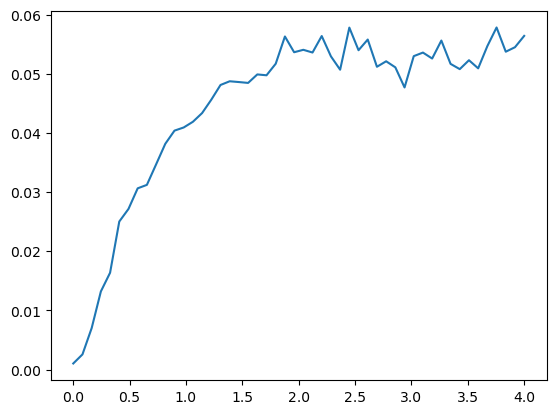

In [163]:
plt.plot(J, S)


In [141]:
import tqdm
import pandas as pd
import seaborn as sns
from collections import defaultdict
T = np.logspace(1, 2, 20).astype("int")
J = 1.
N, M = 5, 5
n_samples = 100
K = 100

g = graphinf.graph.ErdosRenyiModel(N, M)
data = defaultdict(list)
for t in tqdm.tqdm(T):
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=J, length=t)
    X = np.zeros((n_samples, K, g.get_size(), x.get_length()))

    for i in range(n_samples):
        x.sample_prior()
        for j in range(K):
            x.sample_state(1)
            X[i,j] = np.array(x.get_past_states())
    Y_X = np.array([X[i].mean(0) for i in range(n_samples)])
    var_Y_X = np.var(Y_X, axis=0)
    var_Y = np.var(X, axis=(0, 1))
    data["sobol"].append(var_Y_X.sum() / var_Y.sum())
    data["var_y_x"].append(var_Y_X.sum())
    data["var_y"].append(var_Y.sum())
    data["T"].append(t)
#     S.append(var_Y_X.sum() / var_Y.sum())
#     print(S[-1])
            
    
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


Text(0, 0.5, 'Sobol main index')

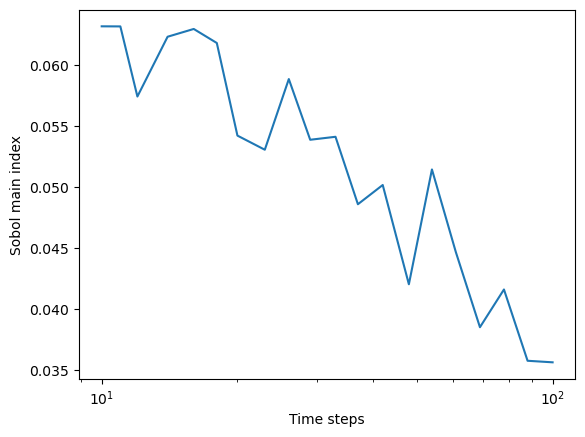

In [143]:
sns.lineplot(pd.DataFrame(data), x="T", y="sobol")
plt.xscale("log")
plt.xlabel("Time steps")
plt.ylabel("Sobol main index")

Text(0, 0.5, 'Sobol main index')

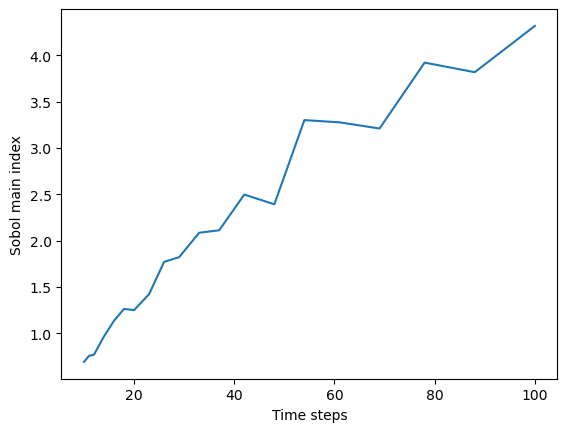

In [145]:
sns.lineplot(pd.DataFrame(data), x="T", y="var_y_x")
# sns.lineplot(pd.DataFrame(data), x="T", y="var_y")
plt.xlabel("Time steps")
plt.ylabel("Sobol main index")

In [194]:
import tqdm
import pandas as pd
import seaborn as sns
from collections import defaultdict
T = np.logspace(1, 2, 20).astype("int")
J = 1.
N, M = 100, 100
n_samples = 200
K = 20

g = graphinf.graph.ErdosRenyiModel(N, M)
data = defaultdict(list)
for t in tqdm.tqdm(T):
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=J, length=t)
    X = np.zeros((n_samples, K, N, t))

    for i in range(n_samples):
        x.sample_prior()
        for j in range(K):
            x.sample_state(1)
            X[i,j] = np.array(x.get_past_states())
    Y_X = np.array([X[i].mean(0) for i in range(n_samples)])

    var_Y_X = np.var(Y_X, axis=0)
    var_Y = np.var(X, axis=(0, 1))
    data["sobol"].append(var_Y_X.sum() / var_Y.sum())
    data["var_y_x"].append(var_Y_X.sum())
    data["var_y"].append(var_Y.sum())
    data["T"].append(t)
#     S.append(var_Y_X.sum() / var_Y.sum())
#     print(S[-1])
            
    
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.11s/it]


Text(0, 0.5, 'Sobol main index')

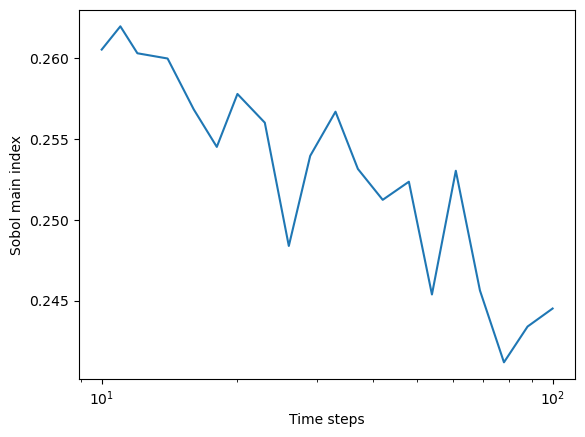

In [193]:
sns.lineplot(pd.DataFrame(data), x="T", y="sobol")
plt.xscale("log")
plt.xlabel("Time steps")
plt.ylabel("Sobol main index")

<Axes: xlabel='T', ylabel='var_y'>

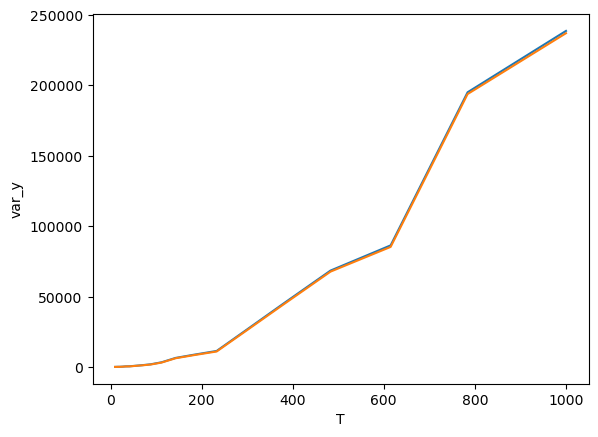

In [152]:
sns.lineplot(pd.DataFrame(data), x="T", y="var_y")
sns.lineplot(pd.DataFrame(data), x="T", y="var_y_x")


In [17]:
G = graphinf.graph.ErdosRenyiModel(5, 5, loopy=False, multigraph=False)
X = graphinf.data.dynamics.GlauberDynamics(G, coupling=0.5, length=100)


In [3]:
def get_transition_matrix(X):
    n = np.array(X.get_past_neighbors_states())
    x = np.array(X.get_past_states())
    y = np.array(X.get_future_states())
    p = np.zeros(x.shape)

    for i in range(x.shape[0]):
        for t in range(x.shape[1]):
            p[i,t] = X.get_transition_prob(x[i, t], y[i, t], n[i, t])
    return p

def get_marginal_transition_matrix(X):
    og = X.get_graph()
    p = np.zeros((X.get_size(), X.get_length()))
    for g in graphinf.utility.enumerate_all_graphs(og.get_size(), og.get_total_edge_number(), False, False):
        X.set_graph(g)
        p += get_transition_matrix(X) * np.exp(X.get_log_prior())
    X.set_graph(og)
    return p
        


In [199]:
J = np.linspace(0, 1, 20)
n_samples = 100

data = defaultdict(list)
for j in tqdm.tqdm(J):
    G = graphinf.graph.ErdosRenyiModel(5, 5, loopy=False, multigraph=False)
    X = graphinf.data.dynamics.SISDynamics(G, infection_prob=j, length=10)
    
    for _ in range(n_samples):
        X.sample(2)
        x = np.array(X.get_past_states())
        y = np.array(X.get_future_states())
        p = get_transition_matrix(X)
        mp = get_marginal_transition_matrix(X)
        p[np.logical_and(x == 0, y==0)] = 1 - p[np.logical_and(x == 0, y==0)]
        p[np.logical_and(x == 1, y==0)] = 1 - p[np.logical_and(x == 1, y==0)]
        
        mp[np.logical_and(x == 0, y==0)] = 1 - mp[np.logical_and(x == 0, y==0)]
        mp[np.logical_and(x == 1, y==0)] = 1 - mp[np.logical_and(x == 1, y==0)]
        if len(np.unique(y)) == 1:
            continue
        data["conditional-auc"].append(roc_auc_score(y.flatten(), p.flatten()))
        data["marginal-auc"].append(roc_auc_score(y.flatten(), mp.flatten()))
        data["conditional-error"].append(np.mean(np.abs(p - y)))
        data["marginal-error"].append(np.mean(np.abs(mp - y)))
        data["evidence"].append(-X.log_evidence(method="exact"))
        data["mi"].append(X.get_log_likelihood() + data["evidence"][-1])
        data["J"].append(j)
    



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.14s/it]


NameError: name 'data' is not defined

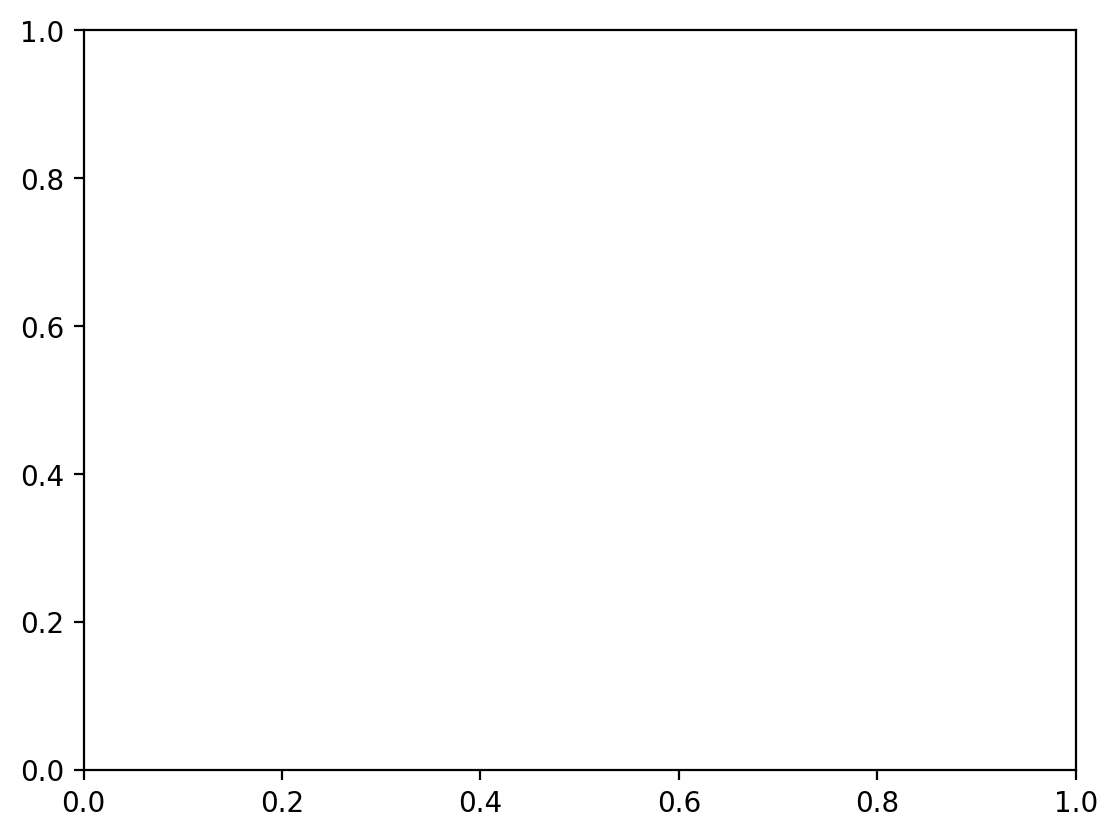

In [2]:
ax = plt.gca()
df = pd.DataFrame(data)
group = df.groupby("J")
pred = group["mi"].mean() / group["evidence"].mean()
score = group["conditional-error"].mean() / group["marginal-error"].mean()

# ax.plot(df.J.unique(), pred, color="blue")
sns.lineplot(df, x="J", y="mi", ax=ax)
axx = ax.twinx()
# ax.plot(df.J.unique(), score, color="cyan")
# axx.plot(df.J.unique(), f_test, color="orange")
# sns.lineplot(df, x="J", y="conditional-error", ax=axx, color="red")
# sns.lineplot(df, x="J", y="marginal-error", ax=axx, color="green")
df["score"] = df["marginal-error"] - df["conditional-error"]
sns.lineplot(df, x="J", y="score", ax=axx, color="cyan")




In [253]:
def get_transition_matrix(X):
    n = np.array(X.get_past_neighbors_states())
    x = np.array(X.get_past_states())
    y = np.array(X.get_future_states())
    p = np.zeros(x.shape)

    for i in range(x.shape[0]):
        for t in range(x.shape[1]):
            p[i,t] = X.get_transition_prob(x[i, t], y[i, t], n[i, t])
    return p

def get_marginal_transition_matrix(X):
    og = X.get_graph()
    p = np.zeros((X.get_size(), X.get_length()))
    for g in graphinf.utility.enumerate_all_graphs(og.get_size(), og.get_total_edge_number(), False, False):
        X.set_graph(g)
        p += get_transition_matrix(X) * np.exp(X.get_log_prior())
    X.set_graph(og)
    return p
        
def mean_absolute_error(x, y):
    return np.abs(x-y).mean()

In [4]:
from sklearn.neural_network import MLPRegressor

In [6]:
MLPRegressor.loss

AttributeError: type object 'MLPRegressor' has no attribute 'loss'

In [ ]:
from sklearn.neural_network import MLPClassifier


J = np.linspace(0, 1, 20)
n_samples = 10

data = defaultdict(list)
for j in tqdm.tqdm(J):
    G = graphinf.graph.ErdosRenyiModel(100, 250, loopy=False, multigraph=False)
    X = graphinf.data.dynamics.GlauberDynamics(G, coupling=j, length=100)
    
    for _ in range(n_samples):
        X.sample()
        x = np.array(X.get_past_states())
        y = np.array(X.get_future_states())
        p = get_transition_matrix(X)
        x_train, y_train = [], []
        for _ in range(20):
            X.sample()
            x_train.append(X.get_past_states())
            y_train.append(X.get_future_states())
        x_train = np.concatenate(x_train, axis=-1)
        y_train = np.concatenate(y_train, axis=-1)
        
        model = MLPClassifier(hidden_layer_sizes=(100,), activation="relu")
        model.fit(x_train.T, y_train.T)
        mp = model.predict_proba(x.T).T
#         mp = []
#         for _ in range(100):
#             mp.append(get_transition_matrix(X))
#             X.sample_prior()
#         mp = np.mean(mp, axis=0)      
#         mp = get_marginal_transition_matrix(X)
        
#         p[y==0] = 1 - p[y == 0]
#         mp[y==0] = 1 - mp[y == 0]
        
#         if len(np.unique(y)) == 1:
#             continue
#         data["conditional-auc"].append(roc_auc_score(y.flatten(), p.flatten()))
#         data["marginal-auc"].append(roc_auc_score(y.flatten(), mp.flatten()))
        data["conditional-error"].append(np.mean(1 - p))
        data["marginal-error"].append(np.mean(1 - mp))
        data["score"].append(np.abs((p - mp)).mean())
#         data["conditional-error"].append(np.abs(p - y).mean())
#         data["marginal-error"].append(np.abs(mp - y).mean())
#         data["evidence"].append(-X.log_evidence(method="exact"))
#         data["mi"].append(X.get_log_likelihood() + data["evidence"][-1])
        data["J"].append(j)
fig, ax = plt.subplots()
df = pd.DataFrame(data)


p = "../../scripts/duality/data/numerical-validation/glauber-large-meanfield/reconinfo.pkl"
reconinf = pd.read_pickle(p)
reconinf = reconinf["glauber-large-meanfield"]
sns.lineplot(reconinf, x="data_model.coupling", y="mutualinfo-loc")

p = "../../scripts/duality/data/numerical-validation/glauber-large-annealed/reconinfo.pkl"
reconinf = pd.read_pickle(p)
reconinf = reconinf["glauber-large-annealed"]
sns.lineplot(reconinf, x="data_model.coupling", y="mutualinfo-loc")

# sns.lineplot(df, x="J", y="mi")
axx = ax.twinx()
sns.lineplot(df, x="J", y="score", color="cyan")
axx.set_ylabel("Mean absolute error")



  0%|                                                                                                                                                               | 0/20 [00:00<?, ?it/s]

In [369]:
import logging
from sklearn.linear_model import LogisticRegression
logging.getLogger("pymc3").setLevel("ERROR")

def linear_model(x_train, y_train):
#     with pymc3.Model() as model:
#         weights = pymc3.Normal("weights", mu=0, sd=1, shape=(5, 5))
#         bias = pymc3.Normal("bias", mu=0, sd=1, shape=(5,))
#         logits = pymc3.math.dot(x_train, weights) + bias
#         probs = pymc3.invlogit(logits)
#         likelihood = pymc3.Bernoulli("likelihood",p=probs, observed=y_train)
#         trace = pymc3.sample(100, tune=100, chains=2, progressbar=True, return_inferencedata=False)
#     return trace.get_values("weights"), trace.get_values("bias")
    model = [LogisticRegression() for i in range(y_train.shape[-1])]
    for i, m in enumerate(model):
        m.fit(x_train, y_train[:, i])
    return model

def mle_model(x_train, y_train):
    for _x, _y in zip(x_train, y_train):
        counts[tuple(_x.tolist())].append(_y)
    return {_x: np.array(_y).mean(0) for _x, _y in counts.items()}
    

In [410]:
data = defaultdict(list)
J = np.linspace(0, 5, 20)
n_samples = 10
for j in tqdm.tqdm(J):

    G = graphinf.graph.ErdosRenyiModel(5, 5, loopy=False, multigraph=False)
    X = graphinf.data.dynamics.GlauberDynamics(G, coupling=j, length=100)
    
    for _ in range(n_samples):
        X.sample()
#         x = np.array(X.get_past_states()).T
#         y = np.array(X.get_future_states()).T
#         p = get_transition_matrix(X).T
#         p[y == 0] = 1 - p[y == 0]
#         mp = get_marginal_transition_matrix(X).T
#         mp[y==0] = 1 - mp[y==0]

#         counts = defaultdict(list)
#         for _x, _y in zip(x, y):
#             counts[tuple(_x.tolist())].append(_y)
#         Y = graphinf.data.dynamics.GlauberDynamics(G, coupling=j, length=100)
#         x_train, y_train = [], []
#         for _ in range(100):
#             Y.sample()
#             x_train.append(np.array(Y.get_past_states()).T)
#             y_train.append(np.array(Y.get_future_states()).T)
#         x_train = np.concatenate(x_train, 0)
#         y_train = np.concatenate(y_train, 0)
#         mle = mle_model(x_train, y_train)
#         mle = np.array([mle[tuple(_x.tolist())] for _x in x])
# #         w, b = linear_model(x_train, y_train)
# #         linear = sigmoid(x @ w + b.reshape(-1, 1, 5))
#         model = linear_model(x_train, y_train)
#         linear = np.array([m.predict_proba(x)[:, 1] for m in model]).T
        
#         data["error-marginal"].append(mean_absolute_error(mp, p))
#         data["error-mle"].append(mean_absolute_error(mle, p))
#         data["error-linear"].append(mean_absolute_error(linear, p))
        data["mi"].append(X.get_log_likelihood() - X.log_evidence(method="exact"))
        data["J"].append(j)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:34<00:00,  4.70s/it]


<Axes: xlabel='J', ylabel='mi'>

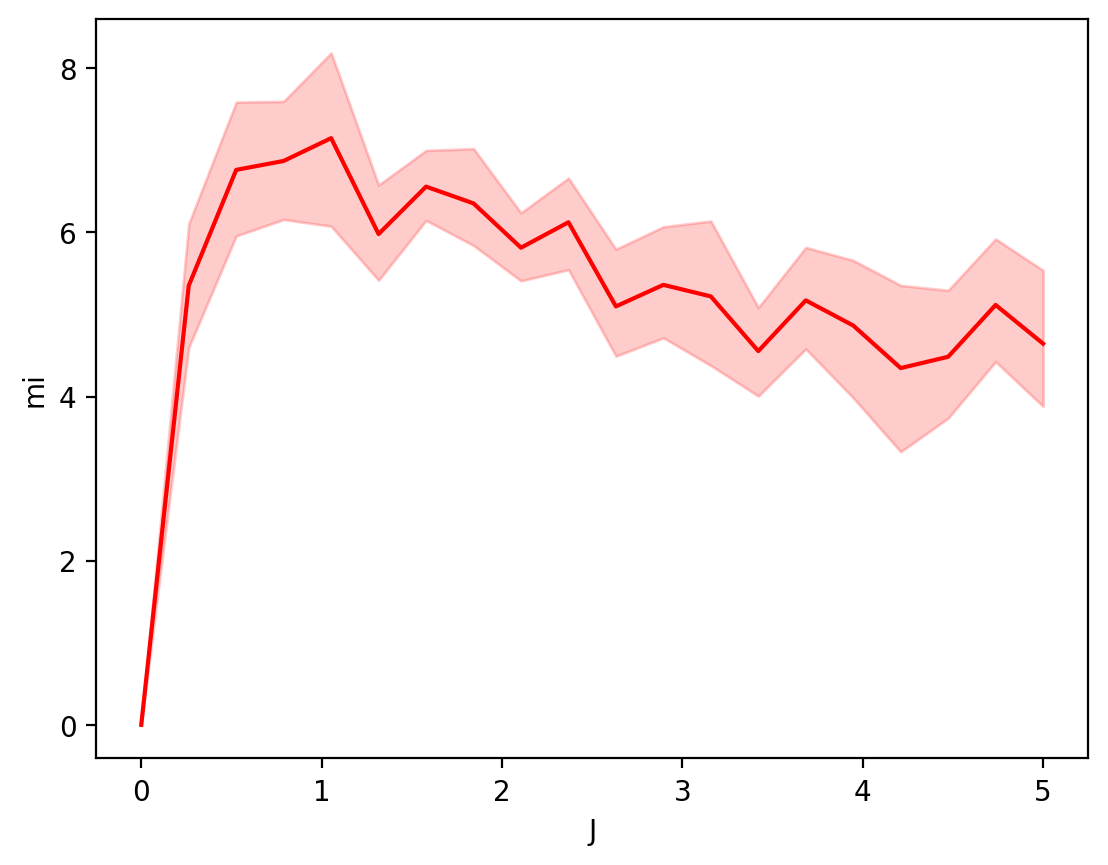

In [411]:
df = pd.DataFrame(data)
sns.lineplot(df, x="J", y="mi", color="red")
# axx = plt.gca().twinx()
# sns.lineplot(df, x="J", y="error-marginal", ax=axx, label="Mean marginal")
# sns.lineplot(df, x="J", y="error-mle", ax=axx, label="MLE")
# sns.lineplot(df, x="J", y="error-linear", ax=axx, label="Logistic")
# axx.set_ylabel("Mean absolute error")


In [404]:
from sklearn.neural_network import MLPClassifier

for j in tqdm.tqdm(J):

    G = graphinf.graph.ErdosRenyiModel(5, 5, loopy=False, multigraph=False)
    X = graphinf.data.dynamics.GlauberDynamics(G, coupling=j, length=100)
    Y = graphinf.data.dynamics.GlauberDynamics(G, coupling=j, length=100)
    
    for _ in range(n_samples):
        X.sample()
        x = np.array(X.get_past_states()).T
        y = np.array(X.get_future_states()).T
        p = get_transition_matrix(X).T
        p[y==0] = 1 - p[y==0]
        x_train, y_train, mp = [], [], []
        for _ in range(100):
            Y.sample()
            x_train.append(np.array(Y.get_past_states()).T)
            y_train.append(np.array(Y.get_future_states()).T)
            
            X.sample_prior()
            mp.append(get_transition_matrix(X).T)
        x_train = np.concatenate(x_train, 0)
        y_train = np.concatenate(y_train, 0)
        mp = np.mean(mp, 0)
        model = MLPClassifier()
        model.fit(x_train, y_train)
        nn = model.predict_proba(x)
        
        model = [LogisticRegression() for _ in range(y_train.shape[-1])]
        logistics = []
        for i, m in enumerate(model):
            m.fit(x_train, y_train[...,i])
            logistics.append(m.predict_proba(x)[:,-1])
        logistics = np.array(logistics).T
        
        print(mean_absolute_error(nn, p), mean_absolute_error(mp, p), mean_absolute_error(logistics, p))
        break
    break
#         nn = mean_absolute_error(model.predict(x_train))
        
#         data["error-nn"].append()
#         data["error-mle"].append(mean_absolute_error(mle, p))
#         data["error-linear"].append(mean_absolute_error(linear, p))
#         data["mi"].append(X.get_log_likelihood() - X.log_evidence(method="exact"))
#         data["J"].append(j)
        

  0%|                                                                                                                                                                                                                  | 0/20 [00:01<?, ?it/s]

0.019388164605568994 0.0 0.010521960180008273


In [337]:
x_train, y_train = [], []
for _ in range(100):
    Y.sample()
    x_train.append(np.array(Y.get_past_states()).T)
    y_train.append(np.array(Y.get_future_states()).T)
#     for _x, _y in zip(x_train, y_train):
#         counts[tuple(_x.tolist())].append(_y)
x_train = np.concatenate(x_train, 0)
y_train = np.concatenate(y_train, 0)

with pymc3.Model() as model:
    weights = pymc3.Normal("weights", mu=0, sd=1, shape=(5, 5))
    bias = pymc3.Normal("bias", mu=0, sd=1, shape=(5,))
    logits = pymc3.math.dot(x_train, weights) + bias
    probs = pymc3.invlogit(logits)
    likelihood = pymc3.Bernoulli("likelihood",p=probs, observed=y_train)
    trace = pymc3.sample(2000, tune=1000, chains=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [bias, weights]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/Users/charlesmurphy/miniconda3/envs/midynet-env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/charlesmurphy/miniconda3/envs/midynet-env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 73 seconds.


In [338]:
w, b = trace.get_values("weights"), trace.get_values("bias")

In [340]:
p = sigmoid(x_train @ w + b.reshape(-1, 1, 5))


In [342]:
p.mean(0)

array([[0.03436683, 0.03886737, 0.8266688 , 0.76693634, 0.6037046 ],
       [0.98135772, 0.96840484, 0.15289411, 0.22556462, 0.2168293 ],
       [0.29263005, 0.19829627, 0.99835023, 0.06486974, 0.97965802],
       ...,
       [0.03995703, 0.0352557 , 0.00109229, 0.0013497 , 0.00715178],
       [0.03995703, 0.0352557 , 0.00109229, 0.0013497 , 0.00715178],
       [0.03995703, 0.0352557 , 0.00109229, 0.0013497 , 0.00715178]])

In [303]:
counts = defaultdict(list)
for _x, _y in zip(x, y):
    counts[tuple(_x.tolist())].append(_y)

for _ in range(1000):
    X.sample()
    x_train = np.array(X.get_past_states()).T
    y_train = np.array(X.get_future_states()).T
    for _x, _y in zip(x_train, y_train):
        counts[tuple(_x.tolist())].append(_y)

In [304]:
model = {_x: np.array(_y).mean(0) for _x, _y in counts.items()}

In [305]:
varp = np.array([model[tuple(_x.tolist())] for _x in x])

In [306]:
mean_absolute_error(varp, p)

0.0328353268058075

In [308]:
varp, p

(array([[0.98393574, 0.98192771, 0.08534137, 0.08232932, 0.08534137],
        [0.98393574, 0.98192771, 0.08534137, 0.08232932, 0.08534137],
        [0.74875869, 0.87189672, 0.8917577 , 0.91956306, 0.89275074],
        [0.98859859, 0.98502706, 0.98895574, 0.98980741, 0.98810407],
        [0.98859859, 0.98502706, 0.98895574, 0.98980741, 0.98810407],
        [0.98859859, 0.98502706, 0.98895574, 0.98980741, 0.98810407],
        [0.98859859, 0.98502706, 0.98895574, 0.98980741, 0.98810407],
        [0.98859859, 0.98502706, 0.98895574, 0.98980741, 0.98810407],
        [0.98859859, 0.98502706, 0.98895574, 0.98980741, 0.98810407],
        [0.98859859, 0.98502706, 0.98895574, 0.98980741, 0.98810407],
        [0.98859859, 0.98502706, 0.98895574, 0.98980741, 0.98810407],
        [0.98859859, 0.98502706, 0.98895574, 0.98980741, 0.98810407],
        [0.98859859, 0.98502706, 0.98895574, 0.98980741, 0.98810407],
        [0.98859859, 0.98502706, 0.98895574, 0.98980741, 0.98810407],
        [0.98859859,

In [282]:
p

array([[9.82013790e-01, 1.79862100e-02, 9.82013790e-01, 6.14417460e-06,
        5.00000000e-01],
       [1.79862100e-02, 9.82013790e-01, 1.79862100e-02, 9.99993856e-01,
        5.00000000e-01],
       [9.82013790e-01, 1.79862100e-02, 9.82013790e-01, 6.14417460e-06,
        5.00000000e-01],
       [6.14417460e-06, 9.82013790e-01, 1.79862100e-02, 9.82013790e-01,
        5.00000000e-01],
       [9.99993856e-01, 1.79862100e-02, 9.82013790e-01, 1.79862100e-02,
        5.00000000e-01],
       [1.79862100e-02, 9.82013790e-01, 1.79862100e-02, 9.99993856e-01,
        5.00000000e-01],
       [9.82013790e-01, 1.79862100e-02, 9.82013790e-01, 6.14417460e-06,
        5.00000000e-01],
       [6.14417460e-06, 9.82013790e-01, 1.79862100e-02, 9.82013790e-01,
        5.00000000e-01],
       [9.99993856e-01, 1.79862100e-02, 9.82013790e-01, 1.79862100e-02,
        5.00000000e-01],
       [6.14417460e-06, 9.82013790e-01, 1.79862100e-02, 9.82013790e-01,
        5.00000000e-01],
       [9.99993856e-01, 1.7986

In [283]:
varp

array([[0.81075697, 0.0498008 , 0.84063745, 0.03984064, 0.84661355],
       [0.13226453, 0.96392786, 0.15831663, 0.96593186, 0.14428858],
       [0.81075697, 0.0498008 , 0.84063745, 0.03984064, 0.84661355],
       [0.02426343, 0.89601386, 0.02946274, 0.90294627, 0.90294627],
       [0.97377049, 0.14918033, 0.97377049, 0.1147541 , 0.09836066],
       [0.13226453, 0.96392786, 0.15831663, 0.96593186, 0.14428858],
       [0.81075697, 0.0498008 , 0.84063745, 0.03984064, 0.84661355],
       [0.02426343, 0.89601386, 0.02946274, 0.90294627, 0.90294627],
       [0.97377049, 0.14918033, 0.97377049, 0.1147541 , 0.09836066],
       [0.02426343, 0.89601386, 0.02946274, 0.90294627, 0.90294627],
       [0.97377049, 0.14918033, 0.97377049, 0.1147541 , 0.09836066],
       [0.13226453, 0.96392786, 0.15831663, 0.96593186, 0.14428858],
       [0.81075697, 0.0498008 , 0.84063745, 0.03984064, 0.84661355],
       [0.13226453, 0.96392786, 0.15831663, 0.96593186, 0.14428858],
       [0.97377049, 0.14918033, 0.

In [10]:
X.log_evidence(method="exact"), np.log(mp).sum()

(-64.40703677112045, -239.93672061542577)

In [47]:
from sklearn.neural_network import MLPClassifier

In [98]:
X = graphinf.data.dynamics.GlauberDynamics(G, coupling=1, length=1000)
x_train, y_train = [], []
for _ in range(10):
    X.sample()
    x_train.append(X.get_past_states())
    y_train.append(X.get_future_states())
x_train = np.concatenate(x_train, axis=-1).T
y_train = np.concatenate(y_train, axis=-1).T

X.sample()
x_test = np.array(X.get_past_states()).T
y_test = np.array(X.get_future_states()).T
p_test = get_transition_matrix(X).T
p_test[y_test == 0] = 1 - p_test[y_test == 0]

m = MLPClassifier(hidden_layer_sizes=(), verbose=True, learning_rate_init=0.001, activation="identity")
m.fit(x_train, y_train)
print("Train: ", m.score(x_train, y_train))
print("Test: ", m.score(x_test, y_test))



Iteration 1, loss = 39.49263805
Iteration 2, loss = 25.72454687
Iteration 3, loss = 24.25460159
Iteration 4, loss = 23.25103983
Iteration 5, loss = 22.37721589
Iteration 6, loss = 21.56887861
Iteration 7, loss = 20.81127964
Iteration 8, loss = 20.09587069
Iteration 9, loss = 19.41384635
Iteration 10, loss = 18.76693388
Iteration 11, loss = 18.15565070
Iteration 12, loss = 17.57000303
Iteration 13, loss = 17.01533696
Iteration 14, loss = 16.48982612
Iteration 15, loss = 15.98716437
Iteration 16, loss = 15.51137878
Iteration 17, loss = 15.05834242
Iteration 18, loss = 14.62697695
Iteration 19, loss = 14.21716872
Iteration 20, loss = 13.82706782
Iteration 21, loss = 13.45432367
Iteration 22, loss = 13.10036156
Iteration 23, loss = 12.76201675
Iteration 24, loss = 12.44046835
Iteration 25, loss = 12.13336884
Iteration 26, loss = 11.84002069
Iteration 27, loss = 11.56072101
Iteration 28, loss = 11.29383877
Iteration 29, loss = 11.03755370
Iteration 30, loss = 10.79289699
Iteration 31, loss 

In [90]:
MLPClassifier?

In [99]:
p_test

array([[8.80797078e-01, 9.99664650e-01, 5.00000000e-01, ...,
        1.19202922e-01, 5.00000000e-01, 8.80797078e-01],
       [9.97527377e-01, 5.00000000e-01, 5.00000000e-01, ...,
        1.19202922e-01, 5.00000000e-01, 9.97527377e-01],
       [9.97527377e-01, 5.00000000e-01, 5.00000000e-01, ...,
        1.19202922e-01, 3.35350130e-04, 1.19202922e-01],
       ...,
       [9.99999168e-01, 9.99993856e-01, 5.00000000e-01, ...,
        8.80797078e-01, 9.99993856e-01, 9.97527377e-01],
       [9.99999168e-01, 9.99993856e-01, 5.00000000e-01, ...,
        8.80797078e-01, 9.99993856e-01, 9.97527377e-01],
       [9.99999168e-01, 9.99993856e-01, 5.00000000e-01, ...,
        8.80797078e-01, 9.99993856e-01, 9.97527377e-01]])

In [100]:
m.predict_proba(x_test)

array([[0.89555082, 0.39948505, 0.82765317, ..., 0.37341386, 0.92065987,
        0.93093574],
       [0.93839839, 0.9375594 , 0.96464442, ..., 0.89543641, 0.92957523,
        0.90372005],
       [0.84485325, 0.61869257, 0.29069847, ..., 0.77415711, 0.59217103,
        0.74909978],
       ...,
       [0.99722985, 0.99365755, 0.99935993, ..., 0.99864375, 0.99834712,
        0.99565011],
       [0.99150834, 0.98766198, 0.99900711, ..., 0.99887296, 0.99827284,
        0.99329103],
       [0.99636859, 0.99343922, 0.9995277 , ..., 0.99764901, 0.99876394,
        0.99561679]])

In [86]:
m.score(x_test, y_test)

0.523

In [34]:
def sigmoid(x):
    return 1 / (1  +np.exp(-x))

_logits = trace.get_values("coeff") @ x + trace.get_values("intercept")
_probs = sigmoid(_logits)

In [39]:
# _probs.mean(0)
p = get_transition_matrix(X)
p[y == 0] = 1 - p[y == 0]

In [45]:
np.abs(p - _probs).mean()

0.030666039388685742

In [42]:
_probs.mean(0)

array([[0.90487455, 0.83261763, 0.88835875, ..., 0.0805216 , 0.07967804,
        0.02680979],
       [0.88056956, 0.07555749, 0.89572934, ..., 0.06782037, 0.02925242,
        0.02434201],
       [0.85989208, 0.0751178 , 0.87834488, ..., 0.04794121, 0.03033189,
        0.02429991],
       ...,
       [0.94569958, 0.95662365, 0.94413066, ..., 0.05919704, 0.02992929,
        0.06117416],
       [0.08696179, 0.87950657, 0.04931652, ..., 0.04798297, 0.02369857,
        0.03239011],
       [0.8435352 , 0.06157716, 0.86957611, ..., 0.09508116, 0.02627561,
        0.03574856]])

In [329]:
p = "../../scripts/duality/data/numerical-validation/glauber-large-meanfield/reconinfo.pkl"
reconinf = pd.read_pickle(p)

In [330]:
reconinfo = reconinf["glauber-large-meanfield"]


In [331]:
reconinfo

,data_model.coupling,evidence-loc,evidence-scale,prior-loc,prior-scale,likelihood-loc,likelihood-scale,posterior-loc,posterior-scale,mutualinfo-loc,mutualinfo-scale,recon-loc,recon-scale,pred-loc,pred-scale
0,0.000000,100002.554512,0.020096,1426.210632,0.0,100000.000000,0.000000,1423.656120,0.020096,2.554512,0.020096,0.001791,0.000014,0.000026,2.009461e-07
1,0.022222,99983.430294,5.162028,1426.210632,0.0,99816.246105,5.801821,1259.026443,1.007780,167.184189,1.007780,0.117223,0.000707,0.001672,9.993144e-06
2,0.044444,99851.850735,9.970163,1426.210632,0.0,99280.848079,12.710105,855.207976,3.655986,571.002656,3.655986,0.400363,0.002563,0.005718,3.604312e-05
3,0.066667,99370.208939,13.030286,1426.210632,0.0,98395.591262,15.522100,451.592955,2.997509,974.617677,2.997509,0.683362,0.002102,0.009808,2.887896e-05
4,0.088889,98389.717720,17.374540,1426.210632,0.0,97172.049200,18.662807,208.542113,2.339897,1217.668519,2.339897,0.853779,0.001641,0.012376,2.159646e-05
5,0.111111,96925.034775,29.020793,1426.210632,0.0,95616.934931,28.862718,118.110788,1.893630,1308.099844,1.893630,0.917186,0.001328,0.013496,1.549616e-05
6,0.133333,95001.141586,37.803101,1426.210632,0.0,93673.252922,36.280256,98.321968,1.884743,1327.888664,1.884743,0.931061,0.001322,0.013978,1.427716e-05
7,0.155556,92703.344709,44.909455,1426.210632,0.0,91368.730184,45.643312,91.596106,1.535896,1334.614526,1.535896,0.935777,0.001077,0.014397,9.593521e-06
8,0.177778,89750.647260,73.367737,1426.210632,0.0,88411.403060,74.481290,86.966433,1.608754,1339.244199,1.608754,0.939023,0.001128,0.014922,5.726671e-06
9,0.200000,85680.179248,124.804687,1426.210632,0.0,84332.884131,125.389215,78.915515,1.082366,1347.295117,1.082366,0.944668,0.000759,0.015725,1.027251e-05


In [389]:

G = graphinf.graph.ErdosRenyiModel(100, 250, loopy=False, multigraph=False)
X = graphinf.data.dynamics.GlauberDynamics(G, coupling=1, length=200)


In [504]:
from sklearn.neural_network import MLPClassifier

G = graphinf.graph.ErdosRenyiModel(50, 100, loopy=False, multigraph=False)
X = graphinf.data.dynamics.GlauberDynamics(G, coupling=1, length=200)

with_graph = False
x, y = [], []
n_samples = 100
for _ in range(n_samples):
    X.sample()
    if with_graph:
        a = np.array(G.get_state().get_adjacency_matrix(True)).flatten()
        x.append(np.concatenate([X.get_past_states(), a.reshape(-1, 1).repeat(200, 1)], axis=0))
    else:
        x.append(X.get_past_states())
    y.append(X.get_future_states())
x_train = np.array(x).transpose(0, 2, 1).reshape(X.get_length() * n_samples, -1)
y_train = np.array(y).transpose(0, 2, 1).reshape(X.get_length() * n_samples, -1)


X.sample()
if with_graph:
    a = np.array(G.get_state().get_adjacency_matrix(True)).flatten()
    x_test = np.concatenate([X.get_past_states(), a.reshape(-1, 1).repeat(200, 1)], axis=0).T
else:
    x_test = np.array(X.get_past_states()).T
y_test = np.array(X.get_future_states()).T
p_test = get_transition_matrix(X).T
p[y_test==0] = 1 - p[y_test==0]


In [505]:
m = MLPClassifier()
print("Training sizes: ", x_train.shape, y_train.shape)
m.fit(x_train, y_train)

pred = m.predict_proba(x_test)
print("Predicted log-likelihood: ", np.log(pred[y_test==1]).sum() + np.log(1 - pred[y_test==0]).sum())
print("true log-likelihood: ", np.log(p[y_test==1]).sum() + np.log(1 - p[y_test==0]).sum())

Training sizes:  (20000, 50) (20000, 50)
Predicted log-likelihood:  -1139.96406304722
true log-likelihood:  -7852.789073273383


In [502]:
from sklearn.neural_network import MLPClassifier

G = graphinf.graph.ErdosRenyiModel(50, 100, loopy=False, multigraph=False)
X = graphinf.data.dynamics.GlauberDynamics(G, coupling=1, length=200)

with_graph = True
x, y = [], []
n_samples = 100
for _ in range(n_samples):
    X.sample()
    if with_graph:
        a = np.array(G.get_state().get_adjacency_matrix(True)).flatten()
        x.append(np.concatenate([X.get_past_states(), a.reshape(-1, 1).repeat(200, 1)], axis=0))
    else:
        x.append(X.get_past_states())
    y.append(X.get_future_states())
x_train = np.array(x).transpose(0, 2, 1).reshape(X.get_length() * n_samples, -1)
y_train = np.array(y).transpose(0, 2, 1).reshape(X.get_length() * n_samples, -1)


X.sample()
if with_graph:
    a = np.array(G.get_state().get_adjacency_matrix(True)).flatten()
    x_test = np.concatenate([X.get_past_states(), a.reshape(-1, 1).repeat(200, 1)], axis=0).T
else:
    x_test = np.array(X.get_past_states()).T
y_test = np.array(X.get_future_states()).T
p_test = get_transition_matrix(X).T
p[y_test==0] = 1 - p[y_test==0]


In [503]:
m = MLPClassifier()
print("Training sizes: ", x_train.shape, y_train.shape)
m.fit(x_train, y_train)

pred = m.predict_proba(x_test)
print("Predicted log-likelihood: ", np.log(pred[y_test==1]).sum() + np.log(1 - pred[y_test==0]).sum())
print("true log-likelihood: ", np.log(p[y_test==1]).sum() + np.log(1 - p[y_test==0]).sum())

Training sizes:  (20000, 2550) (20000, 50)
Predicted log-likelihood:  -4659.2413971641045
true log-likelihood:  -3506.7890732555306


In [495]:
np.log(pred[y_test==1]).sum() + np.log(1 - pred[y_test==0]).sum()

-993.3476276027639

In [496]:
np.log(p[y_test==1]).sum() + np.log(1 - p[y_test==0]).sum()

-464.7890732554675

In [380]:
P

array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
       [0.73105858, 0.73105858, 0.73105858, 0.73105858, 0.73105858,
        0.73105858, 0.95257413, 0.95257413, 0.73105858, 0.95257413,
        0.95257413, 0.95257413, 0.95257413, 0.04742587, 0.95257413,
        0.73105858, 0.95257413, 0.73105858, 0.73105858, 0.95257413],
       [0.73105858, 0.73105858, 0.73105858, 0.73105858, 0.73105858,
        0.73105858, 0.95257413, 0.95257413, 0.73105858, 0.95257413,
        0.95257413, 0.95257413, 0.95257413, 0.95257413, 0.73105858,
        0.26894142, 0.73105858, 0.73105858, 0.73105858, 0.95257413],
       [0.88079708, 0.88079708, 0.88079708, 0.88079708, 0.88079708,
        0.88079708, 0.88079708, 0.88079708, 0.88079708, 0.88079708,
        0.88079708, 0.88079708, 0.88079708, 0

In [379]:
m.predict_proba(x)

array([[3.20281973e-01, 2.25119104e-01, 5.72072266e-01, ...,
        6.94498111e-02, 4.63297891e-02, 8.12453408e-02],
       [3.91796711e-01, 2.12800941e-01, 6.60069015e-01, ...,
        9.24396578e-03, 3.45611374e-03, 9.70738867e-03],
       [1.34700114e-01, 8.75849789e-01, 2.63413955e-02, ...,
        7.88971809e-04, 3.46417668e-04, 1.28208163e-03],
       ...,
       [1.22573477e-01, 9.59987790e-01, 4.43539140e-02, ...,
        2.26949913e-04, 3.53450751e-05, 3.69289909e-04],
       [8.23368767e-01, 4.22805356e-02, 9.49495097e-01, ...,
        1.56857972e-03, 5.02760240e-04, 7.56635992e-04],
       [1.70793762e-01, 7.98275741e-01, 8.46362210e-02, ...,
        1.65569199e-02, 8.10088925e-03, 2.33082827e-02]])

In [382]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

In [383]:
nn_with_g = MLPClassifier()
nn_without_g = MLPClassifier()

nn_with_g.fit(x_with_g, y)
print("With G: ", roc_auc_score(y.flatten(), nn_with_g.predict_proba(x_with_g).flatten()))

nn_without_g.fit(x_without_g, y)
print("Without G: ", roc_auc_score(y.flatten(), nn_without_g.predict_proba(x_without_g).flatten()))


With G:  0.9667865546858487
Without G:  0.5555520088883215


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [248]:
pred = nn.predict_proba(x).flatten()
classification_report(y.flatten().astype("int"), pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [1]:
import midynet, graphinf, matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns

from scipy.linalg import det
from tqdm import notebook as tqdm
from collections import defaultdict

In [19]:
N, M = 100, 250

sobol = []
J = np.linspace(0, 4, 20)
g = graphinf.graph.ErdosRenyiModel(N, M, with_self_loops=False, with_parallel_edges=False)

for _J in tqdm.tqdm(J):
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=_J, length=50)

    n_samples = 20
    samples_v0 = []
    samples_v1 = []
    for _ in range(n_samples):
        x.sample_prior()
        s = []
        x.sample_state(1)
        x0 = x.get_state()
        for _ in  range(100):
            x.sample_state(x0)
            s.append(x.get_log_likelihood())
            samples_v1.append(x.get_log_likelihood())
        samples_v0.append(np.var(s))
        
    v0 = np.mean(samples_v0)
    v1 = np.var(samples_v1)
    sobol.append((v1 - v0)/v1)
    print(_J, sobol[-1])


  0%|          | 0/20 [00:00<?, ?it/s]

0.0 -0.7777777777777778
0.21052631578947367 0.09810713918156268
0.42105263157894735 0.2932098952546853
0.631578947368421 0.5769900788909644
0.8421052631578947 0.8425207584410466
1.0526315789473684 0.8249728516290957
1.263157894736842 0.8558970350244874
1.4736842105263157 0.8936022917821046
1.6842105263157894 0.8857820983821101
1.894736842105263 0.8961242519113013
2.1052631578947367 0.9461013710091961
2.3157894736842106 0.911009046472751
2.526315789473684 0.9514568152903421
2.7368421052631575 0.975378393036187
2.9473684210526314 0.9768047313109338
3.1578947368421053 0.9927665752507626
3.3684210526315788 0.9824025917579998
3.578947368421052 0.9952803050031767
3.789473684210526 0.9890544038291201
4.0 0.9961476450480308


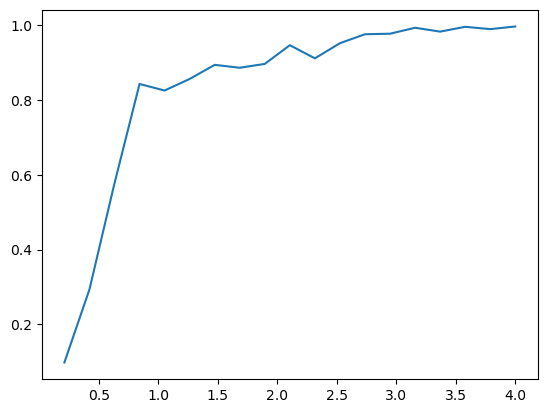

In [21]:
plt.plot(J[1:], sobol[1:])

In [25]:
data = defaultdict(list)

for _J in tqdm.tqdm(J[::2]):
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=_J, length=10)
    x0 = x.get_state()
    for _ in range(20):
        x.sample(x0)
        data["hg"].append(x.get_log_prior())
        data["hxg"].append(x.get_log_likelihood())
        data["hgx"].append(x.get_log_posterior(method="meanfield", n_sweeps=1000, n_steps_per_vertex=5))
        data["hx"].append(data["hg"][-1] + data["hxg"][-1] - data["hgx"][-1])
        data["J"].append(_J)
    print(_J, data["hgx"][-1] - data["hg"][-1])
    
df = pd.DataFrame(data)
df["pred"] = 1 - df["hxg"] / df["hx"]
df["mi"] = df["hgx"] - df["hg"]
sns.lineplot(df, x="J", y="mi")
sns.lineplot(df, x="J", y="pred")


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Axes: xlabel='J', ylabel='pred'>

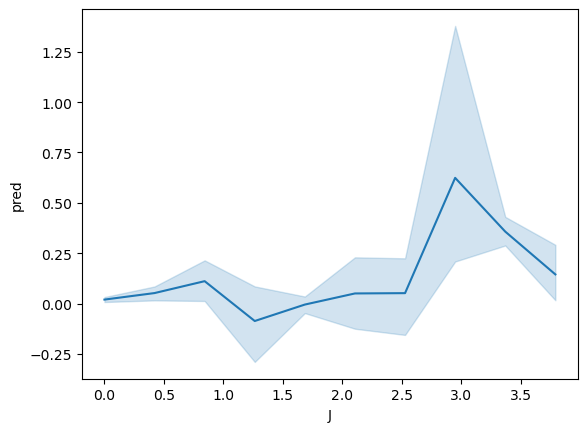

In [24]:
sns.lineplot(df, x="J", y="pred")

In [1]:
import midynet, graphinf, matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns

from collections import defaultdict
from tqdm import notebook as tqdm

In [3]:
g0 = graphinf.utility.load_graph("../../data/graphs/polblogs.npy")

g = graphinf.graph.ConfigurationModel(g0)

  0%|          | 0/21 [00:00<?, ?it/s]

<Axes: xlabel='coupling', ylabel='X'>

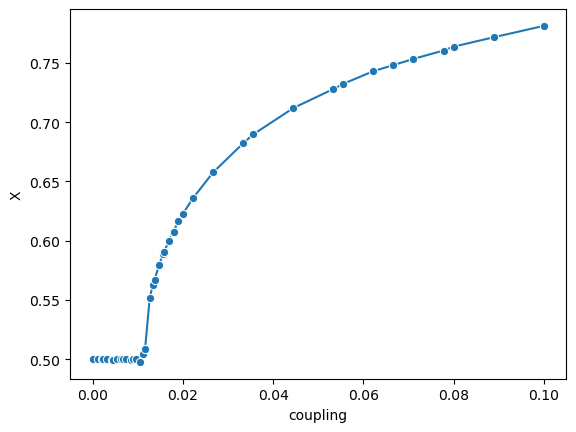

In [10]:
coup = np.concatenate([np.linspace(0, 0.02, 20), np.linspace(0, 0.08, 1)])
# data = defaultdict(list)
n_samples = 1
for c in tqdm.tqdm(coup):
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=c, length=2*g.get_size())
    for i in range(n_samples):
        x.sample(g.get_size())
        X = x.get_future_states()
        data["X"].append(np.mean(X))
        data["coupling"].append(c)
df = pd.DataFrame(data)
sns.lineplot(df, x="coupling", y="X", marker="o")

In [52]:
data = defaultdict(list)
for c in tqdm.tqdm(coup):
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=c, length=2*g.get_size())
    x.freeze_param()
    x.freeze_graph_prior()
    
    for _ in range(10):
        x.sample(g.get_size())
        data["hg"].append(x.get_log_prior())
        data["hxg"].append(x.get_log_likelihood())
        data["hgx"].append(x.get_log_posterior(method="meanfield", n_sweeps=1000, n_steps_per_vertex=2, verbose=False))
        data["hx"].append(data["hg"][-1] + data["hxg"][-1] - data["hgx"][-1])
        data["coupling"].append(c)

df = pd.DataFrame(data)
df["mi"] = df["hgx"] - df["hg"]
df["recon"] = df["mi"] /-df["hg"]
df["pred"] = df["mi"] /-df["hx"]
        
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
axx = ax.twinx()
sns.lineplot(df, x="coupling", y="recon", ax=ax, label="Recon.")
sns.lineplot(df, x="coupling", y="pred", ax=axx, label="Pred.")


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Axes: xlabel='coupling', ylabel='recon'>

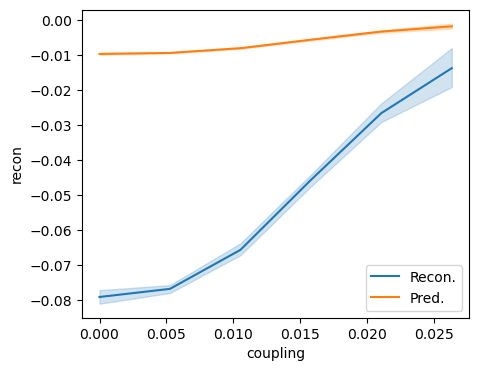

In [62]:
df = pd.DataFrame(data)
df["mi"] = df["hgx"] - df["hg"]
df["recon"] = df["mi"] /-df["hg"]
df["pred"] = df["mi"] /-df["hx"]
        
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# axx = ax.twinx()
sns.lineplot(df, x="coupling", y="recon", ax=ax, label="Recon.")
sns.lineplot(df, x="coupling", y="pred", ax=ax, label="Pred.")

In [ ]:
fig,
sns.lineplot()

In [7]:
g0 = midynet.config.GraphFactory.build(midynet.config.GraphConfig.euairlines())
g = graphinf.graph.ConfigurationModel(g0)

In [21]:
inf = np.linspace(0, 0.06, 20)
data = defaultdict(list)
n_samples = 50
for i in tqdm.tqdm(inf):
    
    x = graphinf.data.dynamics.SISDynamics(g, infection_prob=i, length=2*g.get_size())
    for _ in range(n_samples):
        x.sample(10)
        X = x.get_future_states()
        data["X"].append(np.mean(X))
        data["infection"].append(i)
df = pd.DataFrame(data)
sns.lineplot(df, x="infection", y="X")

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='infection', ylabel='X'>

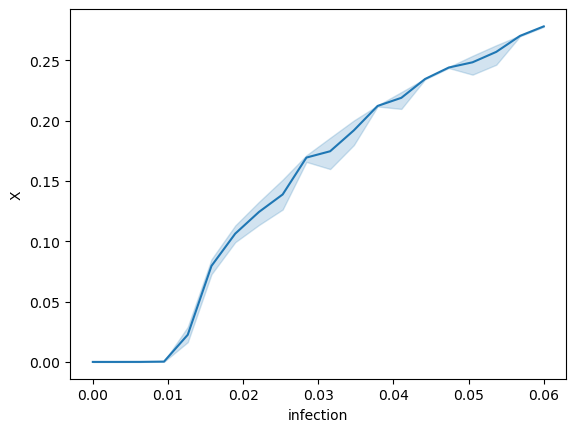

In [22]:
df = pd.DataFrame(data)
sns.lineplot(df, x="infection", y="X")

In [91]:
g0 = midynet.config.GraphFactory.build(midynet.config.GraphConfig.celegans())
g = graphinf.graph.ConfigurationModel(g0)


nu = np.append(np.linspace(0, 0.3, 20), np.linspace(0.05, 0.12, 20))
np.sort(nu)

data = defaultdict(list)
n_samples = 10
for _nu in tqdm.tqdm(nu):
    
    x = graphinf.data.dynamics.CowanDynamics(g, nu=_nu, a=8., eta=0.1, length=2 * g.get_size())
    for _ in range(n_samples):
        x.sample(5)
        X = np.array(x.get_past_states())

        x.sample(g.get_size() - 5)
        Y = np.array(x.get_past_states())
        data["forward"].append(np.mean(X))
        data["backward"].append(np.mean(Y))
        data["nu"].append(_nu)


    
    

  0%|          | 0/40 [00:00<?, ?it/s]

<Axes: xlabel='nu', ylabel='forward'>

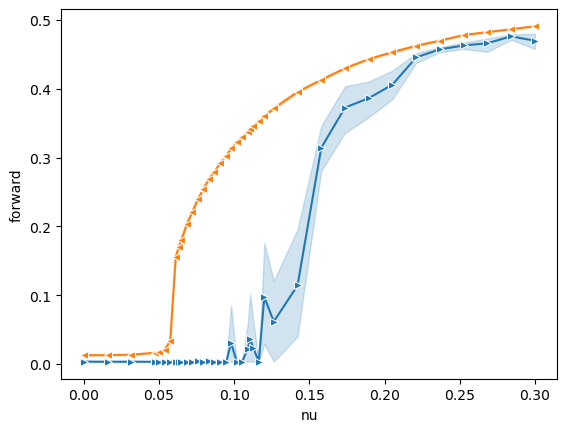

In [92]:
df = pd.DataFrame(data)
sns.lineplot(df, x="nu", y="forward", marker=">")
sns.lineplot(df, x="nu", y="backward", marker="<")


In [90]:
np.sort?

In [11]:
import pymc3, logging, numpy as np
logger = logging.getLogger("pymc3")


In [13]:
logger.setLevel("ERROR")

In [90]:
n = 100
X = np.random.randn(n, n)
a, b, s = 4, -7, 0.4

Y = a * X + b + np.random.normal(0, s, size=n)

In [91]:
with pymc3.Model() as model:
    # Define the model parameters
    b_ = pymc3.Normal('b', mu=0, sd=1)
    a_ = pymc3.Normal('a', mu=0, sd=1)
    s_ = pymc3.HalfCauchy("s", beta=10)
    
    # Define the likelihood of the observed data
    likelihood = pymc3.Normal("likelihood", mu=a_ * X + b_, sd=s_, observed=Y)
    
    # Perform inference using the No-U-Turn Sampler (NUTS)
    trace = pymc3.sample(1000, tune=500, chains=2, progressbar=True, return_inferencedata=False)

/Users/charlesmurphy/miniconda3/envs/midynet-env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/charlesmurphy/miniconda3/envs/midynet-env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


In [94]:
trace.get_values("a").data.shape

(2000,)

In [65]:
trace.get_values("a").mean(), trace.get_values("b").mean(), trace.get_values("s").mean()

(4.029236207377294, -6.992294801368194, 0.39833021683750147)

In [66]:
trace.get_values("a").var(), trace.get_values("b").var(), trace.get_values("s").var()

(0.0001540817966468901, 0.00016900971744560474, 7.757437251175915e-05)

In [67]:
pymc3.Bernoulli?

In [84]:
trace._report.__dict__["_ess"]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b        float64 2.125e+03
    a        float64 2.591e+03
    s        float64 2.468e+03

In [ ]:
with pymc3.Model() as model:
    # Define the model parameters
    b_ = pymc3.Normal('b', mu=0, sd=1)
    a_ = pymc3.Normal('a', mu=0, sd=1)
    s_ = pymc3.HalfCauchy("s", beta=10)
    
    # Define the likelihood of the observed data
    likelihood = pymc3.Normal("likelihood", mu=a_ * X + b_, sd=s_, observed=Y)
    
    # Perform inference using the No-U-Turn Sampler (NUTS)
    trace = pymc3.sample(1000, tune=500, chains=2, progressbar=True, return_inferencedata=False)

In [88]:
pymc3.invlogit(np.array([0,0,0]))

Elemwise{add,no_inplace}.0